In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

In [2]:
train_data = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')

In [3]:
train_data.iloc[:,[0,1,2]]

,Id,MSSubClass,MSZoning
0,1,60,RL
1,2,20,RL
2,3,60,RL
3,4,70,RL
4,5,60,RL
...,...,...,...
1455,1456,60,RL
1456,1457,20,RL
1457,1458,70,RL
1458,1459,20,RL


In [4]:
train_data['MSSubClass']

0       60
1       20
2       60
3       70
4       60
        ..
1455    60
1456    20
1457    70
1458    20
1459    20
Name: MSSubClass, Length: 1460, dtype: int64

In [5]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [6]:
num_feature = all_features.dtypes[all_features.dtypes != 'object'].index

In [7]:
num_feature

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

减去平均值除以方差，标准化

In [8]:
all_features[num_feature] = all_features[num_feature].apply(lambda x:(x-x.mean())/(x.std()))

In [9]:
all_features[num_feature] = all_features[num_feature].fillna(0)

In [13]:
all_features = pd.get_dummies(all_features,dummy_na=True)

In [18]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)

In [24]:
loss = torch.nn.MSELoss()
def get_net(n_train):
    net = nn.Linear(n_train,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)
    return net

定义均方根误差

In [33]:
def log_rmse(net,features,labels):
    with torch.no_grad():
        clip_pred = torch.max(net(features),torch.tensor(1.0))
        rmse = torch.sqrt(loss(clip_pred.log(),labels.log()))
    return rmse.item()

In [22]:
def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(),lr=learning_rate,weight_decay=weight_decay)
    net = net.float()
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))
    return train_ls,test_ls

In [23]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train,y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j == i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat((X_train,X_part),dim=0)
            y_train = torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid

In [39]:
def k_fold(k,X_train,y_train,num_epo,lr,wd,bs):
    train_l_sum,valid_l_sum = 0.0,0.0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net(X_train.shape[1])
        train_ls,valid_ls = train(net,*data,num_epo,lr,wd,bs)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.semilogy(range(1,num_epo+1),train_ls,'epo','rmse',range(1,num_epo+1),valid_ls,['train','valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.183263, valid rmse 0.163745
fold 1, train rmse 0.183890, valid rmse 0.184270
fold 2, train rmse 0.183185, valid rmse 0.181802
fold 3, train rmse 0.179744, valid rmse 0.211410
fold 4, train rmse 0.179968, valid rmse 0.214961
fold 5, train rmse 0.184570, valid rmse 0.162343
fold 6, train rmse 0.183818, valid rmse 0.161189
fold 7, train rmse 0.182880, valid rmse 0.174483
fold 8, train rmse 0.178055, valid rmse 0.218374
fold 9, train rmse 0.183135, valid rmse 0.167212
10-fold validation: avg train rmse 0.182251, avg valid rmse 0.183979


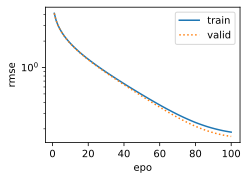

In [42]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 3, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

fold 0, train rmse 0.143200, valid rmse 0.156482
fold 1, train rmse 0.143575, valid rmse 0.123053
fold 2, train rmse 0.144216, valid rmse 0.139077
fold 3, train rmse 0.140352, valid rmse 0.171138
fold 4, train rmse 0.138810, valid rmse 0.169553
fold 5, train rmse 0.143370, valid rmse 0.118839
fold 6, train rmse 0.144889, valid rmse 0.130063
fold 7, train rmse 0.142317, valid rmse 0.153391
fold 8, train rmse 0.138257, valid rmse 0.195092
fold 9, train rmse 0.143721, valid rmse 0.140381
10-fold validation: avg train rmse 0.142271, avg valid rmse 0.149707


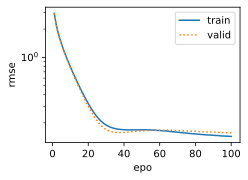

In [43]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 10, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

fold 0, train rmse 0.314572, valid rmse 0.294039
fold 1, train rmse 0.312268, valid rmse 0.334786
fold 2, train rmse 0.313362, valid rmse 0.319863
fold 3, train rmse 0.311224, valid rmse 0.336046
fold 4, train rmse 0.311744, valid rmse 0.340754
fold 5, train rmse 0.314218, valid rmse 0.309544
fold 6, train rmse 0.314144, valid rmse 0.288624
fold 7, train rmse 0.314658, valid rmse 0.299678
fold 8, train rmse 0.310895, valid rmse 0.344087
fold 9, train rmse 0.313904, valid rmse 0.289742
10-fold validation: avg train rmse 0.313099, avg valid rmse 0.315716


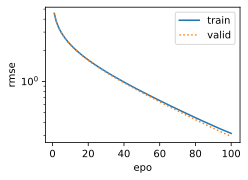

In [44]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 3, 0, 100
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

In [45]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./submission.csv', index=False)

train rmse 0.140108


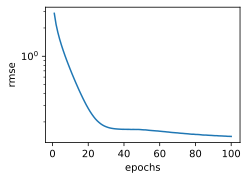

In [46]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 10, 0, 64
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)